# Neural Networks
In practice

In [1]:
# Global imports and settings
from preamble import *
import keras
print("Using Keras",keras.__version__)
%matplotlib inline
plt.rcParams['figure.dpi'] = 125 # Use 300 for PDF, 100 for slides
# InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

Using TensorFlow backend.


Using Keras 2.1.5


### Overview
* Solving basic classification and regression problems
* Model selection (and overfitting)

## Solving basic problems
* Binary classification (of movie reviews)
* Multiclass classification (of news topics)
* Regression (of house prices)

Examples from _Deep Leaerning with Python_

### Components of Neural Nets (recap)
* _Layers_ of nodes: transform an input tensor to an output tensor
    - Each with (a tensor of) weights to be optimized to fit the training data
    - Many types: dense, convolutional, recurrent,...
* _Loss function_: Measures whether the model fits the training data
* _Optimizer_: How to update the network, e.g. SGD

<img src="../images/09_overview.png" alt="ml" style="width: 600px;"/>

### Binary classification
* Dataset: 50,000 IMDB reviews, labeled positive (1) or negative (0)
    - Included in Keras, with a 50/50 train-test split
* Each row is one review, with only the 10,000 most frequent words retained
* Each word is replaced by a _word index_ (word ID)

In [2]:
from keras.datasets import imdb
# Download IMDB data with 10000 most frequent words
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
print("Encoded review: ", train_data[0][0:10])

word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
print("Original review: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]][0:10]))


Encoded review:  [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
Original review:  ? this film was just brilliant casting location scenery story


#### Preprocessing
* We can't input lists of categorical value to a neural net, we need to create tensors
* One-hot-encoding:
    -  10000 features, '1.0' if the word occurs
* Word embeddings (word2vec):
    - Map each word to a dense vector that represents it (it's _embedding_)
    - _Embedding_ layer: pre-trained layer that looks up the embedding in a dictionary 
    - Converts 2D tensor of word indices (zero-padded) to 3D tensor of embeddings
* Let's do One-Hot-Encoding for now. We'll come back to _Embedding_ layers.
* Also vectorize the labels: from 0/1 to float
    - Binary classification works with one output node

In [3]:
# Custom implementation of one-hot-encoding
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
print("Encoded review: ", train_data[0][0:10])
print("One-hot-encoded review: ", x_train[0][0:10])

# Convert 0/1 labels to float
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

print("Label: ", y_train[0])

Encoded review:  [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
One-hot-encoded review:  [0. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
Label:  1.0


#### Building the network
* We can solve this problem using a network of _Dense_ layers and the _ReLU_ activation function.
* How many layers? How many hidden units for layer?
    - Start with 2 layers of 16 hidden units each
    - We'll optimize this soon
* Output layer: single unit with _sigmoid_ activation function
    - Close to 1: positive review, close to 0: negative review

#### Cross-entropy loss
* We've seen _cross-entropy loss_ (or _log loss_) over $C$ classes before
    - Measures how similar the actual and predicted probability distributions are
    - Compute cross-entropy $H(y,\hat{y})$ between true $y$ and predicted $\hat{y}$
    - Sum up over all training samples
$$ H(y,\hat{y}) = - \sum_{c=1}^C y_c \log(\hat{y}_c)$$

* For binary classification, this simplifies to 
$$ - \sum_{c=0,1} y_c \log(\hat{y}_c) = −(y \log(\hat{y})+ (1−y) \log(1−\hat{y}))$$

<img src="../images/09_cross-entropy.png" alt="ml" style="width: 600px;"/>

In [4]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

For more control, you can explictly create the optimizer, loss, and metrics:

``` python
from keras import optimizers
from keras import losses
from keras import metrics
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
```

#### Model selection
* How many epochs do we need for training?
* Take a validation set of 10,000 samples from the training set
* Train the neural net and track the loss after every iteration on the validation set
    - This is returned as a `History` object by the `fit()` function 
* We start with 20 epochs in minibatches of 512 samples

In [5]:
x_val, partial_x_train = x_train[:10000], x_train[10000:]
y_val, partial_y_train = y_train[:10000], y_train[10000:] 
history = model.fit(partial_x_train, partial_y_train,
                    epochs=20, batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 4s 243us/step - loss: 0.5085 - acc: 0.7814 - val_loss: 0.3794 - val_acc: 0.8693
Epoch 2/20
15000/15000 [==============================] - 2s 115us/step - loss: 0.3005 - acc: 0.9046 - val_loss: 0.3002 - val_acc: 0.8899
Epoch 3/20
15000/15000 [==============================] - 2s 115us/step - loss: 0.2179 - acc: 0.9285 - val_loss: 0.3082 - val_acc: 0.8715
Epoch 4/20
15000/15000 [==============================] - 2s 142us/step - loss: 0.1751 - acc: 0.9437 - val_loss: 0.2838 - val_acc: 0.8835
Epoch 5/20
15000/15000 [==============================] - 2s 139us/step - loss: 0.1427 - acc: 0.9543 - val_loss: 0.2848 - val_acc: 0.8865
Epoch 6/20
15000/15000 [==============================] - 2s 133us/step - loss: 0.1150 - acc: 0.9652 - val_loss: 0.3146 - val_acc: 0.8774
Epoch 7/20
15000/15000 [==============================] - 2s 144us/step - loss: 0.0980 - acc: 0.9707 - val_loss: 0.3126 - 

We can now retrieve visualize the loss on the validation data
* The training loss keeps decreasing, due to gradient descent
* The validation loss peaks after a few epochs, after which the model starts to overfit

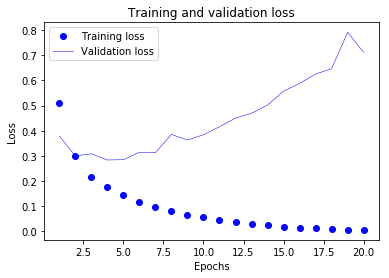

In [6]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

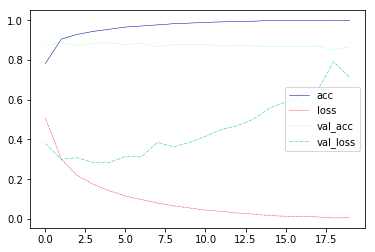

In [7]:
# Alternative plotting code
pd.DataFrame(history.history).plot();

We can also visualize the accuracy, with similar findings

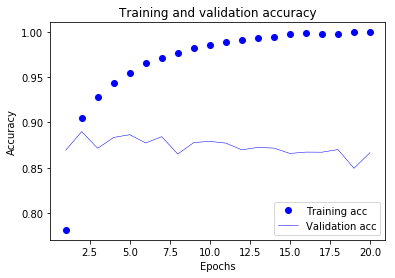

In [8]:
plt.clf()   # clear figure
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Early stopping
One simple technique to avoid overfitting is to use the validation set to 'tune' the optimal number of epochs

In [9]:
model.fit(x_train, y_train, epochs=4, batch_size=512)
result = model.evaluate(x_test, y_test)
print("Loss: {:.4f}, Accuracy: {:.4f}".format(*result))

Epoch 1/4
25000/25000 [==============================] - 2s 83us/step - loss: 0.2226 - acc: 0.9457
Epoch 2/4
25000/25000 [==============================] - 2s 78us/step - loss: 0.1419 - acc: 0.9582
Epoch 3/4
25000/25000 [==============================] - 2s 77us/step - loss: 0.1122 - acc: 0.9668
Epoch 4/4
25000/25000 [==============================] - 4s 162us/step
Loss: 0.5101, Accuracy: 0.8592


#### Predictions
Out of curiosity, let's look at a few predictions:

In [10]:
predictions = model.predict(x_test)
print("Review 0: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in test_data[0]]))
print("Predicted positiveness: ", predictions[0])
print("\nReview 9: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in test_data[9]]))
print("Predicted positiveness: ", predictions[9])

Review 0:  ? please give this one a miss br br ? ? and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite ? so all you madison fans give this a miss
Predicted positiveness:  [0.016]

Review 9:  ? this film is where the batman franchise ought to have stopped though i will ? that the ideas behind batman forever were excellent and could have been easily realised by a competent director as it turned out this was not to be the case br br apparently warner brothers executives were disappointed with how dark this second batman film from tim burton turned out apart from the idiocy of expecting anything else from burton and the conservative ? of their subsequent decision to turn the franchise into an homage to the sixties tv series i fail to understand how batman returns can be considered at all disappoin

#### Takeaways
* Neural nets require a lot of preprocessing to create tensors
* Dense layers with ReLU activation can solve a wide range of problems
* Binary classification can be donw with a Dense layer with a single unit, sigmoid activation, and binary cross-entropy loss
* Neural nets overfit easily
* Many design choices have an effect on accuracy and overfitting. Try:
    - 1 or 3 hidden layers
    - more or fewer hidden units (e.g. 64)
    - MSE loss instead of binary cross-entropy
    - `tanh` activation instead of `ReLU`

### Wrapping Keras models as scikit-learn estimators
* Model selection can be tedious in pure Keras
* We can use all the power of scikit-learn by wrapping Keras models

``` python
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
clf = KerasClassifier(model)
```

In [11]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV

def make_model(optimizer="adam", hidden_size=32):
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

clf = KerasClassifier(make_model)
param_grid = {'epochs': [1, 5, 10],  # epochs is fit parameter, not in make_model!
              'hidden_size': [32, 64, 256]}
grid = GridSearchCV(clf, param_grid=param_grid, cv=3)
grid.fit(x_train, y_train)

Epoch 1/1
16666/16666 [==============================] - 1s 70us/step
Epoch 1/1
16667/16667 [==============================] - 1s 71us/step
Epoch 1/1
16667/16667 [==============================] - 1s 65us/step
Epoch 1/1
16666/16666 [==============================] - 1s 84us/step
Epoch 1/1
16667/16667 [==============================] - 1s 73us/step
Epoch 1/1
16667/16667 [==============================] - 2s 113us/step
Epoch 1/1
16666/16666 [==============================] - 1s 76us/step
Epoch 1/1
16667/16667 [==============================] - 1s 79us/step
Epoch 1/1
16667/16667 [==============================] - 1s 81us/step
Epoch 1/5
16666/16666 [==============================] - 3s 169us/step - loss: 0.3404 - acc: 0.8607
Epoch 2/5
16666/16666 [==============================] - 2s 141us/step - loss: 0.2042 - acc: 0.9218
Epoch 3/5
16666/16666 [==============================] - 2s 145us/step - loss: 0.1620 - acc: 0.9384
Epoch 4/5
16666/16666 [==============================] - 2s 140us/ste

16666/16666 [==============================] - 2s 127us/step - loss: 0.0828 - acc: 0.9707
Epoch 8/10
16666/16666 [==============================] - 2s 121us/step - loss: 0.0694 - acc: 0.9749
Epoch 9/10
16666/16666 [==============================] - 2s 123us/step - loss: 0.0578 - acc: 0.9803
Epoch 10/10
16666/16666 [==============================] - 1s 65us/step
Epoch 1/10
16667/16667 [==============================] - 3s 207us/step - loss: 0.3407 - acc: 0.8583
Epoch 2/10
16667/16667 [==============================] - 2s 138us/step - loss: 0.2050 - acc: 0.9241
Epoch 3/10
16667/16667 [==============================] - 2s 134us/step - loss: 0.1612 - acc: 0.9414
Epoch 4/10
16667/16667 [==============================] - 2s 145us/step - loss: 0.1354 - acc: 0.9508
Epoch 5/10
16667/16667 [==============================] - 2s 144us/step - loss: 0.1143 - acc: 0.9604
Epoch 6/10
16667/16667 [==============================] - 2s 143us/step - loss: 0.0968 - acc: 0.9677
Epoch 7/10
16667/16667 [======

16667/16667 [==============================] - 3s 163us/step - loss: 0.0558 - acc: 0.9821
Epoch 10/10
16667/16667 [==============================] - 1s 84us/step
Epoch 1/10
16667/16667 [==============================] - 5s 285us/step - loss: 0.3472 - acc: 0.8585
Epoch 2/10
16667/16667 [==============================] - 4s 248us/step - loss: 0.2068 - acc: 0.9224
Epoch 3/10
16667/16667 [==============================] - 2s 126us/step - loss: 0.1676 - acc: 0.9389
Epoch 4/10
16667/16667 [==============================] - 2s 128us/step - loss: 0.1389 - acc: 0.9486
Epoch 5/10
16667/16667 [==============================] - 2s 137us/step - loss: 0.1228 - acc: 0.9555
Epoch 6/10
16667/16667 [==============================] - 2s 145us/step - loss: 0.1054 - acc: 0.9635
Epoch 7/10
16667/16667 [==============================] - 2s 127us/step - loss: 0.0914 - acc: 0.9677
Epoch 8/10
16667/16667 [==============================] - 2s 133us/step - loss: 0.0783 - acc: 0.9743
Epoch 9/10
16667/16667 [======

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x1c2e90d0f0>,
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'epochs': [1, 5, 10], 'hidden_size': [32, 64, 256]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [12]:
res = pd.DataFrame(grid.cv_results_)
res.pivot_table(index=["param_epochs", "param_hidden_size"],
                values=['mean_train_score', "mean_test_score"])

mean_test_score  mean_train_score
param_epochs param_hidden_size                                   
1            32                            0.89              0.94
             64                            0.89              0.93
             256                           0.89              0.93
5            32                            0.88              0.97
             64                            0.88              0.98
             256                           0.88              0.97
10           32                            0.87              0.99
             64                            0.87              0.99
             256                           0.87              0.99

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 197us/step - loss: 0.5372 - acc: 0.7767 - val_loss: 0.4068 - val_acc: 0.8600
Epoch 2/20
15000/15000 [==============================] - 2s 102us/step - loss: 0.3089 - acc: 0.9006 - val_loss: 0.2991 - val_acc: 0.8859
Epoch 3/20
15000/15000 [==============================] - 2s 101us/step - loss: 0.2166 - acc: 0.9287 - val_loss: 0.3049 - val_acc: 0.8762
Epoch 4/20
15000/15000 [==============================] - 2s 105us/step - loss: 0.1679 - acc: 0.9424 - val_loss: 0.2783 - val_acc: 0.8893
Epoch 5/20
15000/15000 [==============================] - 2s 105us/step - loss: 0.1380 - acc: 0.9537 - val_loss: 0.2833 - val_acc: 0.8896
Epoch 6/20
15000/15000 [==============================] - 2s 102us/step - loss: 0.1070 - acc: 0.9655 - val_loss: 0.3157 - val_acc: 0.8852
Epoch 7/20
15000/15000 [==============================] - 2s 145us/step - loss: 0.0904 - acc: 0.9717 - val_loss: 0.3334 - 

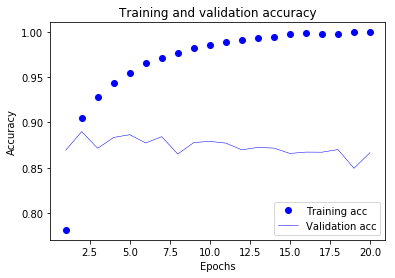

In [13]:
# Three hidden layers
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(partial_x_train, partial_y_train,
                    epochs=20, batch_size=512,
                    validation_data=(x_val, y_val))
plt.clf()   # clear figure
acc_values = history.history['acc']
val_acc_values = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Multi-class classification (topic classification)
* Dataset: 11,000 news stories, 46 topics
    - Included in Keras, with a 50/50 train-test split
* Each row is one news story, with only the 10,000 most frequent words retained
* Each word is replaced by a _word index_ (word ID)

In [14]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
print("News wire: ",decoded_newswire)
print("Encoded: ", train_data[0][0:20])
print("Topic: ",train_labels[0])

News wire:  ? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
Encoded:  [1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7]
Topic:  3


#### Preparing the data
* We have to vectorize the data again (using one-hot-encoding)
* We have to vectorize the labels as well, also using one-hot-encoding
    - We can use Keras' `to_categorical` again
    - This yields a vector of 46 floats (0/1) for every sample

In [15]:
from keras.utils.np_utils import to_categorical
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

#### Building the network
* _Information bottleneck_: Every layer can `drop` some information, which can never be recovered by subsequent layers
* 16 hidden units may be too limited to learn 46 topics, hence we use 64 in each layer
* The output layer now needs 46 units, one for each topic
    - We use `softmax` activation for the output to get probabilities]
* The loss function is now `categorical_crossentropy`

In [16]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Model selection
* Take a validation set from the training set
* Fit again with 20 epochs

In [17]:
x_val, partial_x_train = x_train[:1000], x_train[1000:]
y_val, partial_y_train = one_hot_train_labels[:1000], one_hot_train_labels[1000:]

In [18]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 68s 8ms/step - loss: 2.5322 - acc: 0.4955 - val_loss: 1.7208 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 3s 411us/step - loss: 1.4452 - acc: 0.6877 - val_loss: 1.3458 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 2s 209us/step - loss: 1.0953 - acc: 0.7653 - val_loss: 1.1713 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 1s 152us/step - loss: 0.8698 - acc: 0.8156 - val_loss: 1.0803 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 1s 174us/step - loss: 0.7034 - acc: 0.8479 - val_loss: 0.9843 - val_acc: 0.7820
Epoch 6/20
7982/7982 [==============================] - 1s 166us/step - loss: 0.5665 - acc: 0.8799 - val_loss: 0.9417 - val_acc: 0.8030
Epoch 7/20
7982/7982 [==============================] - 2s 203us/step - loss: 0.4580 - acc: 0.9048 - val_loss: 0.9086 - val_acc: 0.8020
E

Loss curve:

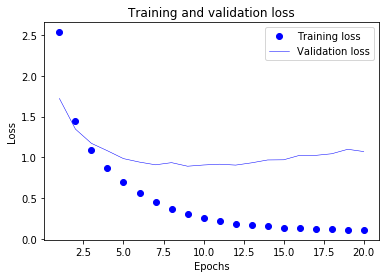

In [19]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Accuracy curve. Overfitting starts after about 8 epochs

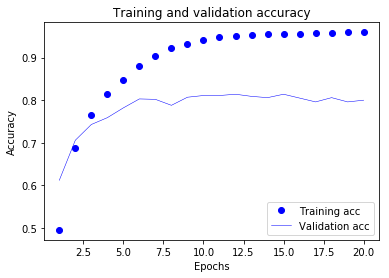

In [20]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Retrain with early stopping and validate

In [21]:
model.fit(partial_x_train, partial_y_train, epochs=8, batch_size=512)
result = model.evaluate(x_test, one_hot_test_labels)
print("Loss: {:.4f}, Accuracy: {:.4f}".format(*result))

Epoch 1/8
7982/7982 [==============================] - 1s 132us/step - loss: 0.1054 - acc: 0.9569
Epoch 2/8
7982/7982 [==============================] - 1s 133us/step - loss: 0.1018 - acc: 0.9580
Epoch 3/8
7982/7982 [==============================] - 1s 129us/step - loss: 0.1026 - acc: 0.9589
Epoch 4/8
7982/7982 [==============================] - 1s 162us/step - loss: 0.1029 - acc: 0.9574
Epoch 5/8
7982/7982 [==============================] - 1s 158us/step - loss: 0.0969 - acc: 0.9587
Epoch 6/8
7982/7982 [==============================] - 1s 140us/step - loss: 0.0987 - acc: 0.9563
Epoch 7/8
7982/7982 [==============================] - 1s 131us/step - loss: 0.0958 - acc: 0.9575
Epoch 8/8
2246/2246 [==============================] - 0s 196us/step
Loss: 1.3821, Accuracy: 0.7640


#### Information bottleneck
* What happens if we create an information bottleneck on purpose
    - Use only 4 hidden units in the second layer
* Accuracy drops dramatically!
* We are trying to learn 64 separating hyperplanes from a 4-dimensional representation
    - It manages to save a lot of information, but also loses a lot

In [22]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128, verbose=0,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 3s 336us/step - loss: 2.4695 - acc: 0.5199 - val_loss: 1.7777 - val_acc: 0.5980
Epoch 2/20
7982/7982 [==============================] - 2s 206us/step - loss: 1.5149 - acc: 0.6124 - val_loss: 1.4549 - val_acc: 0.6210
Epoch 3/20
7982/7982 [==============================] - 2s 196us/step - loss: 1.2249 - acc: 0.6738 - val_loss: 1.3334 - val_acc: 0.6820
Epoch 4/20
7982/7982 [==============================] - 2s 189us/step - loss: 1.0568 - acc: 0.7453 - val_loss: 1.2732 - val_acc: 0.7100
Epoch 5/20
7982/7982 [==============================] - 2s 203us/step - loss: 0.9427 - acc: 0.7612 - val_loss: 1.2580 - val_acc: 0.7210
Epoch 6/20
7982/7982 [==============================] - 2s 192us/step - loss: 0.8541 - acc: 0.7813 - val_loss: 1.2851 - val_acc: 0.7090
Epoch 7/20
7982/7982 [==============================] - 2s 201us/step - loss: 0.7832 - acc: 0.8007 - val_loss: 1.2925 - val_acc: 0.7290


#### Takeaways
* For a problem with $C$ classes, the final Dense layer needs $C$ units
* Use `softmax` activation and `categorical_crossentropy` loss
* Information bottleneck: when classifying many classes, the hidden layers should be large enough
* Many design choices have an effect on accuracy and overfitting. Try:
    - 1 or 3 hidden layers
    - more or fewer hidden units (e.g. 128)

### Regression
* Dataset: 506 examples of houses and sale prices (Boston)
    - Included in Keras, with a 1/5 train-test split
* Each row is one house price, described by numeric properties of the house and neighborhood
* Small dataset, non-normalized features

In [23]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

#### Preprocessing
* Neural nets work a lot better if we normalize the features first. 
* Keras has no built-in support so we have to do this manually (or with scikit-learn)
    - Again, be careful not to look at the test data during normalization

In [24]:
mean, std = train_data.mean(axis=0), train_data.std(axis=0)
train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

#### Building the network
* This is a small dataset, so easy to overfit
    * We use 2 hidden layers of 64 units each
* Use smaller batches, more epochs
* Since we want scalar output, the output layer is one unit without activation
* Loss function is Mean Squared Error (bigger penalty)
* Evaluation metric is Mean Abolute Error (more interpretable)
* We will also use cross-validation, so we wrap the model building in a function, so that we can call it multiple times

In [25]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

#### Cross-validation
* Keras does not have support for cross-validation
* Luckily we can wrap a Keras model as a scikit-learn estimate
* We can also implement cross-validation ourselves 
* Generally speaking, cross-validation is tricky with neural nets
    * Some fold may not converge, or fluctuate on random initialization

In [42]:
# TODO: Check why MAE is different. Should actually use a pipeline
from sklearn.model_selection import cross_val_score
clf = KerasClassifier(build_model)
X = np.concatenate([train_data,test_data],axis=0)
y = np.concatenate([train_targets,test_targets],axis=0)
score = cross_val_score(clf, train_data, train_targets, scoring='neg_mean_absolute_error', cv=4,
                        fit_params={'epochs': 100, 'batch_size':1, 'verbose':0});
print("MAE: ", -np.mean(score))

MAE:  15.936386138613859


In [34]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [41]:
print("MAE: ", np.mean(all_scores))

MAE:  2.4963379927200844


Train for longer and keep track of loss after every epoch

In [43]:
from keras import backend as K
K.clear_session() # Memory clean-up

num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


The model starts overfitting from epoch 80

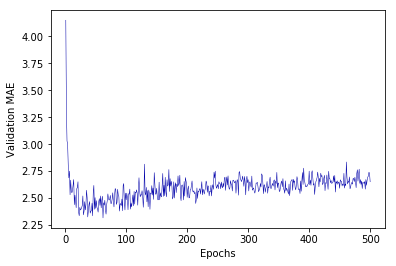

In [44]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Retrain with optimized number of epochs

In [46]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print("MAE: ", test_mae_score)

102/102 [==============================] - 0s 640us/step
MAE:  2.825951931523342


#### Takeaways
* Regression is usually done using MSE loss and MAE for evaluation
* Input data should always be scaled (independent from the test set)
* Small datasets:
    - Use cross-validation
    - Use simple (non-deep) networks
    - Smaller batches, more epochs

### Regularization: build smaller networks
* The easiest way to avoid overfitting is to use a simpler model
* The number of learnable parameters is called the model _capacity_
* A model with more parameters has a higher _memorization capacity_
    - The entire training set can be `stored` in the weights
    - Learns the mapping from training examples to outputs
* Forcing the model to be small forces it to learn a compressed representation that generalizes better
    - Always a trade-off between too much and too little capacity
* Start with few layers and parameters, incease until you see diminisching returns

Let's try this on our movie review data, with 4 units per layer

In [47]:
from keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [49]:
original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])
original_hist = original_model.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=512, verbose=0,
                                   validation_data=(x_test, y_test))
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512, verbose=0,
                                       validation_data=(x_test, y_test))

The smaller model starts overfitting later than the original one, and it overfits more _slowly_

In [50]:
epochs = range(1, 21)
original_val_loss = original_hist.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']

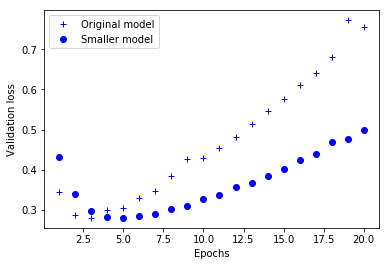

In [51]:
plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, smaller_model_val_loss, 'bo', label='Smaller model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

### Regularization: Weight regularization
* As we did many times before, we can also add weight regularization to our loss function
- L1 regularization: leads to _sparse networks_ with many weights that are 0
- L2 regularization: leads to many very small weights
    - Also called _weight decay_ in neural net literature
* In Keras, add `kernel_regularizer` to every layer

In [52]:
from keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

In [53]:
l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

In [54]:
l2_model_hist = l2_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512, verbose=0,
                             validation_data=(x_test, y_test))

L2 regularized model is much more resistant to overfitting, even though both have the same number of parameters

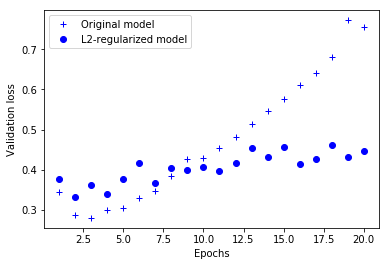

In [55]:
l2_model_val_loss = l2_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, l2_model_val_loss, 'bo', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

You can also try L1 loss or both at the same time
``` python
from keras import regularizers

# L1 regularization
regularizers.l1(0.001)

# L1 and L2 regularization at the same time
regularizers.l1_l2(l1=0.001, l2=0.001)
```

### Regularization: dropout
* One of the most effective and commonly used regularization techniques
* Breakes up accidental non-significant learned patterns 
* Randomly set a number of outputs of the layer to 0
* _Dropout rate_: fraction of the outputs that are zeroed-out
    - Usually between 0.2 and 0.5
* Nothing is dropped out at test time, but the output values are scaled down by the dropout rate
    - Balances out that more units are active than during training
* In Keras: add `Dropout` layers between the normal layers

In [56]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

In [57]:
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size=512, verbose=0,
                               validation_data=(x_test, y_test))

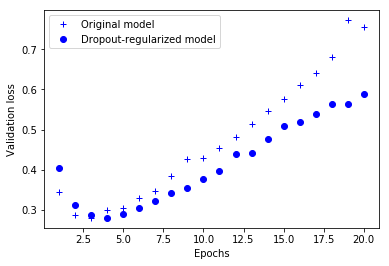

In [58]:
dpt_model_val_loss = dpt_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, dpt_model_val_loss, 'bo', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

### Regularization recap
* Get more training data
* Reduce the capacity of the network
* Add weight regularization
* Add dropout
* Either start with a simple model and add capacity
* Or, start with a complex model and then regularize by adding weight regularization and dropout